In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import os



In [2]:
# Load datasets
historical_data = pd.read_csv('historical_data.csv')
fear_greed_index = pd.read_csv('fear_greed_index.csv')

In [3]:
# Preprocess historical data
# Fill null values
historical_data.fillna('ffill', inplace=True)

In [4]:
# Feature selection
features = historical_data[['Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Closed PnL']].copy()

# Convert categorical features to numerical
features.loc[:, 'Side'] = features['Side'].map({'BUY': 1, 'SELL': 0})

In [5]:
# Target variable
target = historical_data['Closed PnL'] > 0  # Binary classification: profit or loss


In [6]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


In [7]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
# Model building
model_filename = 'trading_model.joblib'

if not os.path.exists(model_filename):
    # If model does not exist, create and train a new model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train)
    
    # Save the model
    joblib.dump(model, model_filename)
    print("Model trained and saved.")
else:
    # If model exists, load the model
    model = joblib.load(model_filename)
    print("Model loaded.")

Model loaded.


In [18]:
# Model evaluation
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Model Accuracy: 1.00
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     24802
        True       1.00      1.00      1.00     17443

    accuracy                           1.00     42245
   macro avg       1.00      1.00      1.00     42245
weighted avg       1.00      1.00      1.00     42245



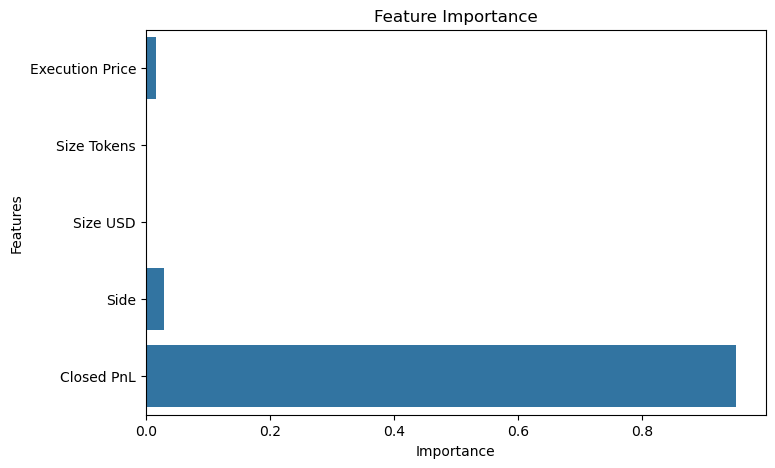

In [20]:
# Visualization of feature importance
feature_importances = model.feature_importances_
features_names = features.columns
plt.figure(figsize=(8, 5))
sns.barplot(x=feature_importances, y=features_names)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [22]:
# Time analysis for sentiment
fear_greed_index['date'] = pd.to_datetime(fear_greed_index['date'])
historical_data['Timestamp IST'] = pd.to_datetime(historical_data['Timestamp IST'], format='%d-%m-%Y %H:%M')


In [24]:
# Merge datasets on date
merged_data = pd.merge(historical_data, fear_greed_index, left_on='Timestamp IST', right_on='date', how='inner')

In [26]:
# Create a new column for trading signal based on sentiment
merged_data['Trading Signal'] = np.where(merged_data['value'] < 20, 'Strong Fear',
                                         np.where(merged_data['value'] < 40, 'Fear',
                                                  np.where(merged_data['value'] < 60, 'Neutral',
                                                           np.where(merged_data['value'] < 80, 'Greed', 'Strong Greed'))))

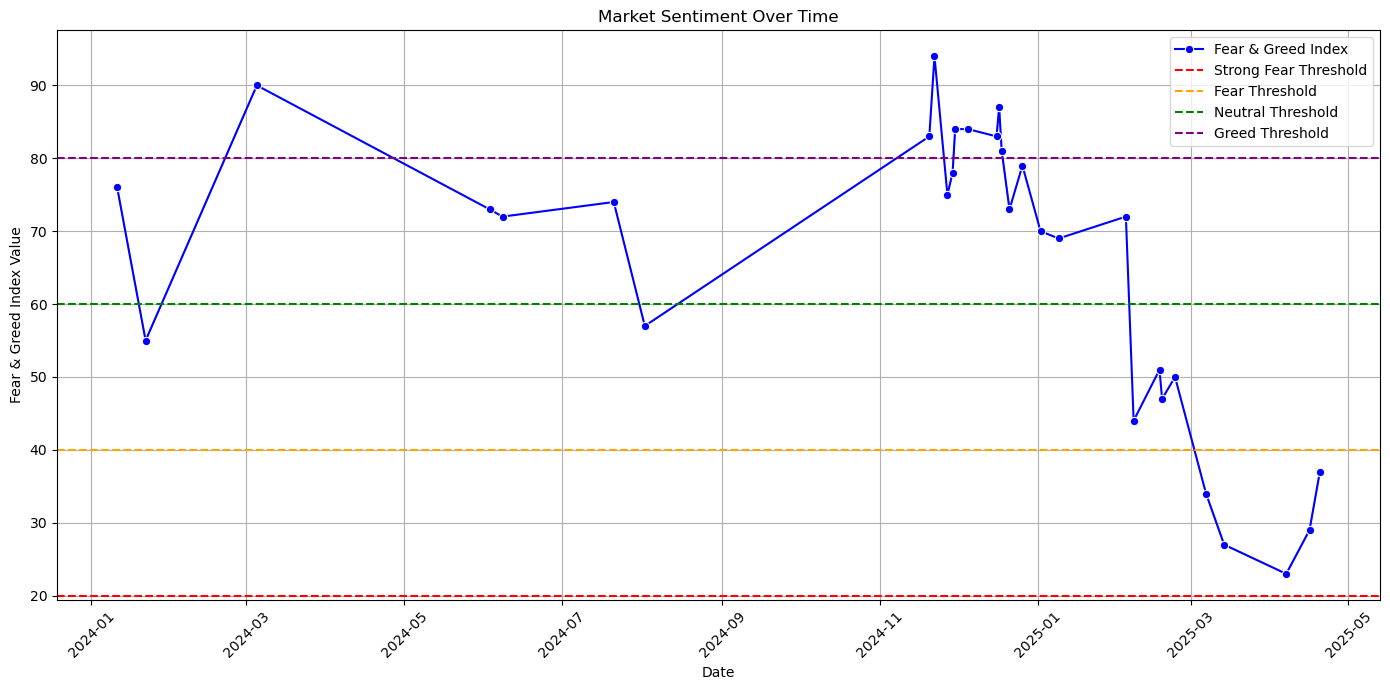

In [28]:
# Visualization of market sentiment over time
plt.figure(figsize=(14, 7))
sns.lineplot(data=merged_data, x='date', y='value', marker='o', color='blue', label='Fear & Greed Index')
plt.axhline(y=20, color='red', linestyle='--', label='Strong Fear Threshold')
plt.axhline(y=40, color='orange', linestyle='--', label='Fear Threshold')
plt.axhline(y=60, color='green', linestyle='--', label='Neutral Threshold')
plt.axhline(y=80, color='purple', linestyle='--', label='Greed Threshold')
plt.title('Market Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Fear & Greed Index Value')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

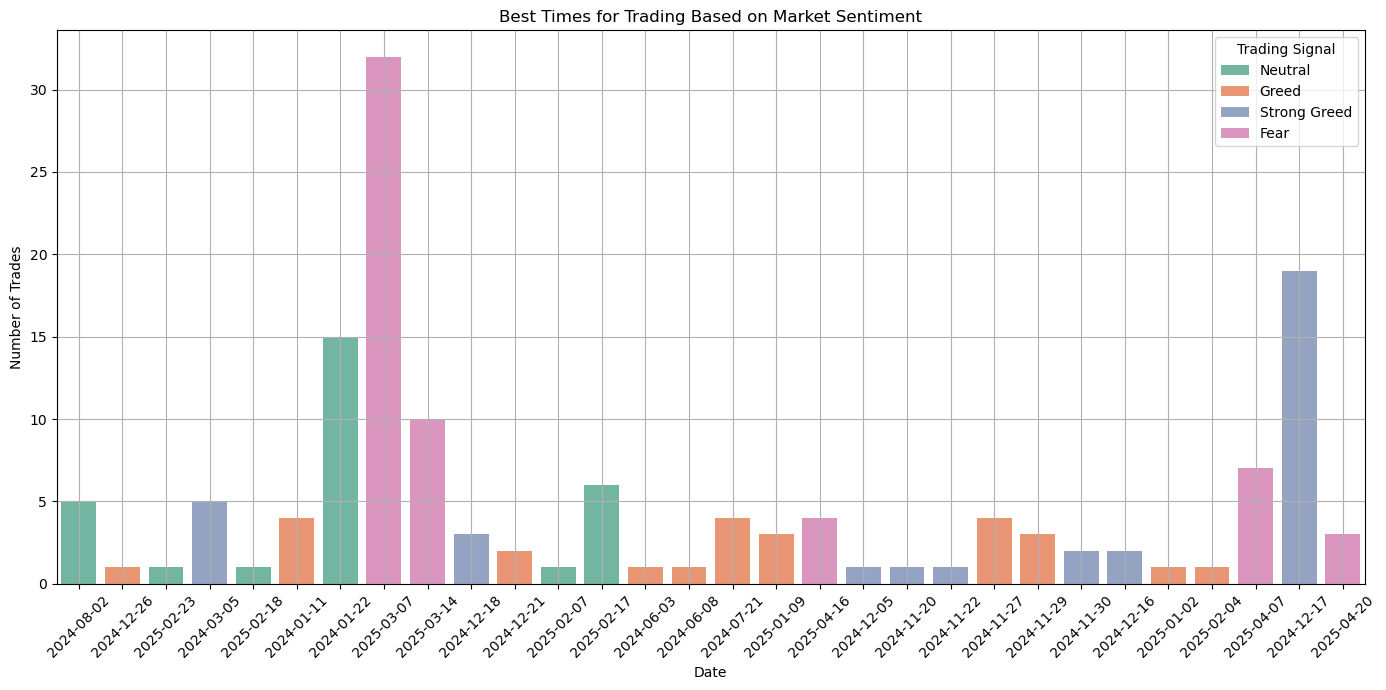

In [30]:
# Best times for trading based on sentiment
plt.figure(figsize=(14, 7))
sns.countplot(data=merged_data, x='date', hue='Trading Signal', palette='Set2')
plt.title('Best Times for Trading Based on Market Sentiment')
plt.xlabel('Date')
plt.ylabel('Number of Trades')
plt.xticks(rotation=45)
plt.legend(title='Trading Signal')
plt.grid()
plt.tight_layout()
plt.show()